## Comparison between precipitation features and convective cells based on CTT 

**Notes:** 
    
Precipitation 
- plot with contribution of total precip > 3000m, from heavy precip > 5mm which are non contiguous/isolated (local precip), contiguous in space (at least 10 pixels), contiguous in space and time (10 pixels and 3 hours), incorporated in precipitating cloud system (combined tracking) 


Method section 
- plot which shows lifetime, nr of tracks and area for each of the 3 methods (precip, tbb, tbb_cold_core, combined)



In [3]:
# read in CTT tracks heavy rain core 
import pandas as pd
F = '/media/juli/Elements/gpm_v06/Save/2000_2019/Features_Precip200006.h5'
f= pd.read_hdf(F, 'table')

In [6]:
# read in cells from precip tracking 
import numpy as np 
import pandas as pd 



# read in precip tracks 
precipfile = '/media/juli/Elements/gpm_v06/Save/Tracks_GPM_2000_2019_5mm.h5'
preciptracks= pd.read_hdf(precipfile, 'table')
preciptracks.timestr = pd.to_datetime(preciptracks.timestr)



# read in CTT tracks heavy rain core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_tbb_2006_heavyraincorefiltered.h5'
tbbtracks= pd.read_hdf(tbb, 'table')
tbbtracks.timestr = pd.to_datetime(tbbtracks.timestr)


# read in CTT tracks cold core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_tbb_2006_cold_core.h5'
tbbcold= pd.read_hdf(tbb, 'table')
tbbcold.timestr = pd.to_datetime(tbbcold.timestr)


# read in CTT tracks only tbb 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_2006.h5'
tbb= pd.read_hdf(tbb, 'table')
tbb.timestr = pd.to_datetime(tbb.timestr)


In [36]:
# get only summer cells 
tracks = preciptracks
for i in np.unique(tracks.time.values):
    if i.month not in [6,7, 8]:
        tracks.drop(tracks.loc[tracks['time']== i].index, inplace=True)

In [37]:
summertracks = tracks 
summertracks.to_hdf('/media/juli/Elements/gpm_v06/Save/Tracks_GPM_2000_2019_JJA.h5', 'table')
n= np.unique(summertracks.timestr).shape[0]
n / (48*90*20) * 100

40.58796296296296

## Diurnal cycle 

In [15]:
# function to get seasonal curve of tracks
def get_diurnal_cycle(preciptracks):
    preciptracks['hour']= preciptracks.timestr.dt.hour
    diurnal=[]
    for h in np.arange(0,23):
        count = preciptracks[preciptracks.hour == h].shape[0]
        #meanvalue= np.nanmean(preciptracks.total_precip.values)
        diurnal.append(count)
    return diurnal

In [65]:
# get dataframe with max values 

def get_max_values(tracks):
    peak_frame = pd.DataFrame(columns = tracks.columns)
    for cell in np.unique(tracks.cell.values):
        subset= tracks[tracks.cell == cell]
        peak = np.nanmax(subset.total_precip.values)
        rain_peak = subset[subset.total_precip == peak]
        # add row to dataframe 
        peak_frame = pd.concat([peak_frame, rain_peak ], ignore_index=True)
    return peak_frame


In [66]:
mcs_precip= get_max_values(tbbtracks)

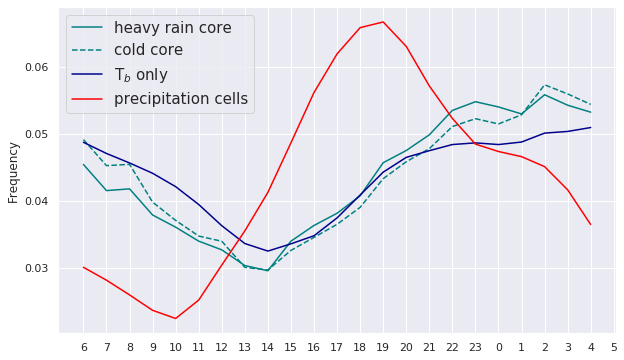

In [69]:
diurnal_precip = get_diurnal_cycle(preciptracks)
diurnal_tbb_rain= get_diurnal_cycle(tbbtracks)
diurnal_tbb_cold= get_diurnal_cycle(tbbcold)
diurnal_tbb= get_diurnal_cycle(tbb)
max_precip = get_diurnal_cycle(mcs_precip)


import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()


a= np.arange(0,18) + 6 
b= np.arange(0,6)
localtime= np.append(a, b)


plt.figure(figsize=(10,6))

plt.plot(diurnal_tbb_rain/ np.nansum(diurnal_tbb_rain), label = 'heavy rain core ', color= 'teal')
plt.plot(diurnal_tbb_cold/ np.nansum(diurnal_tbb_cold), label = 'cold core', color= 'teal', linestyle='--')
plt.plot(diurnal_tbb/ np.nansum(diurnal_tbb), label = 'T$_b$ only', color= 'darkblue')

#plt.plot(max_precip/np.nansum(max_precip), label = 'max precip', color= 'darkred')

plt.plot(diurnal_precip/np.nansum(diurnal_precip), label = 'precipitation cells', color= 'red')
plt.legend(fontsize= 15)

plt.xticks(np.arange(0,24), labels= localtime.astype(str))





plt.ylabel('Frequency')
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/diurnal_cycle_tracking_methods.png')
plt.show()


## Seasonal cycle 

In [3]:
# function to get seasonal curve of tracks

def get_seasonal_cycle(preciptracks):
    preciptracks['month']= preciptracks.timestr.dt.month
    seasonal=[]
    for m in np.arange(1,13):
        monthly_count = preciptracks[preciptracks.month== m].shape[0]   # for frequency 
        #meanvalue= np.nanmean(preciptracks.total_precip.values)    # for mean values of specific variable 
        seasonal.append(monthly_count)
    return seasonal

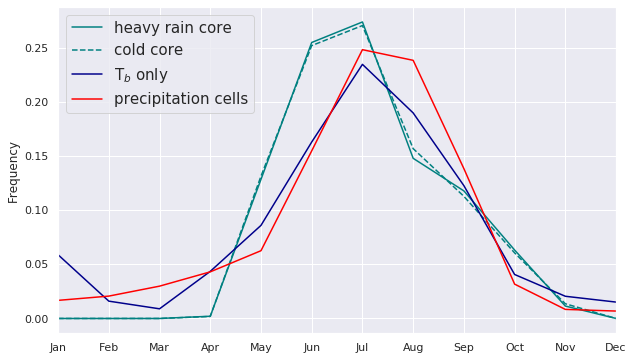

In [258]:
seasonal_precip = get_seasonal_cycle(preciptracks)
seasonal_tbb_rain= get_seasonal_cycle(tbbtracks)
seasonal_tbb_cold= get_seasonal_cycle(tbbcold)
seasonal_tbb= get_seasonal_cycle(tbb)


import seaborn as sns 
sns.set()


plt.figure(figsize=(10,6))

plt.plot(seasonal_tbb_rain/ np.nansum(seasonal_tbb_rain), label = 'heavy rain core ', color= 'teal')
plt.plot(seasonal_tbb_cold/ np.nansum(seasonal_tbb_cold), label = 'cold core', color= 'teal', linestyle='--')
plt.plot(seasonal_tbb/ np.nansum(seasonal_tbb), label = 'T$_b$ only', color= 'darkblue')
plt.plot(seasonal_precip/np.nansum(seasonal_precip), label = 'precipitation cells', color= 'mediumvioletred')
plt.legend(fontsize= 15)

plt.xticks(np.arange(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'])
plt.xlim(0,11)
plt.ylabel('Frequency')
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/seasonal_cycle_tracking_methods.png')
plt.show()

##  lifetime histogram 

In [6]:
def get_lifetime(tracks):
    lt= []
    for cell in np.unique(tracks.cell.values):
        hours= tracks[tracks.cell== cell].shape[0] * 0.5
        lt.append(hours)
    lt = np.array(lt)
    lt= np.histogram(lt, bins=(3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
    print('lifetime histo calculated.')
    return lt

In [7]:
lt_precip = get_lifetime(preciptracks)
lt_tbb_rain= get_lifetime(tbbtracks)
lt_tbb_cold= get_lifetime(tbbcold)
lt_tbb= get_lifetime(tbb)

lifetime histo calculated.
lifetime histo calculated.
lifetime histo calculated.
lifetime histo calculated.


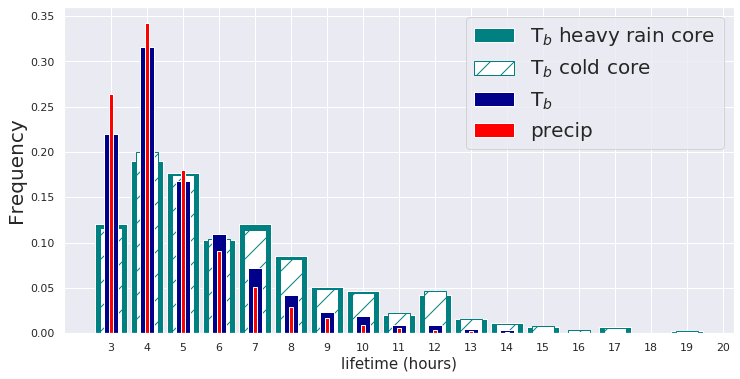

In [12]:
bins = lt_precip[1]
import matplotlib.pyplot as plt

import seaborn as sns 
sns.set()




plt.figure(figsize=(12,6))


plt.bar(bins[:-1] , lt_tbb_rain[0]/ np.nansum(lt_tbb_rain[0]), label= 'T$_b$ heavy rain core', width=0.9,color= 'teal')

plt.bar(bins[:-1] , lt_tbb_cold[0]/ np.nansum(lt_tbb_cold[0]), label = 'T$_b$ cold core', width = 0.6,hatch= '/', edgecolor= 'teal', color= 'white')


plt.bar(bins[:-1] , lt_tbb[0]/ np.nansum(lt_tbb[0]), label= 'T$_b$', width= 0.4, color= 'darkblue')

plt.bar(bins[:-1] , lt_precip[0]/ np.nansum(lt_precip[0]), label='precip', width = 0.1, color= 'red')

plt.legend(fontsize= 20)

plt.xticks(bins[:])
plt.xlabel('lifetime (hours)', fontsize= 15)
plt.ylabel('Frequency', fontsize= 20)

plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/lifetime_tracking_methods.png')
plt.show()

In [4]:
# calculate propagation speed (tobac can be used)
import tobac
preciptracks = tobac.calculate_velocity(preciptracks, method_distance=None)

In [16]:
# calculate area based on ncells 




In [324]:
# divide into north-moving, east-moving and other 

def propagation_dir(tracks):
    pd.options.mode.chained_assignment = None 
    
    tracks['dir'] = 0 
    for c in np.unique(tracks.cell.values):
        cell= tracks[tracks.cell == c]

        west_east= cell.longitude.values[-1] - cell.longitude.values[0]
        north_south = cell.latitude.values[-1] - cell.latitude.values[0]

        if north_south > west_east:
            if np.nanmean(cell.latitude.values[0:2]) < np.nanmean(cell.latitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'N'
            elif np.nanmean(cell.latitude.values[0:2]) > np.nanmean(cell.latitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'S'
                
        elif north_south < west_east:
            if np.nanmean(cell.longitude.values[0:2]) < np.nanmean(cell.longitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'E'
            elif np.nanmean(cell.longitude.values[0:2]) > np.nanmean(cell.longitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'W'
    return tracks 

In [327]:
print(tbb[tbb.dir=='N'].shape,tbb[tbb.dir=='E'].shape, tbb[tbb.dir=='W'].shape, tbb[tbb.dir=='S'].shape)

(16616, 16) (26189, 16) (6152, 16) (9635, 16)


In [325]:
#  separate tracks based on propagation direction, thresholds for intensity, and TP domain vs. surrounding 
tbb = propagation_dir(tbb)

## Contribution to total precipitation 

1. Seasonal curve with contribution to total precipitation, TP vs outside of TP, fraction of convective precip

! fix months for which timestep shape is not equal 
! combine with precip from GPM: fraction of total precip 
 


In [54]:
# get total precipitation from GPM within TP 3000 m boundary 

tp_precip = '/media/juli/Data/projects/mcs_tracking/CTT/analysis/'



In [42]:
tp_tracks = tbbtracks[tbbtracks.tp_flag > 0]

In [69]:
# calculate precip amount per month 

tbbtracks['month']= tbbtracks.timestr.dt.month

seasonal_conv=[]
seasonal_tot=[]

for m in np.arange(1,13):
    p = tbbtracks[tbbtracks.month== m]
    total_precip= np.nansum(p.total_precip.values)
    convective_precip= np.nansum(p.convective_precip.values)
    seasonal_conv.append(convective_precip)
    seasonal_tot.append(total_precip)


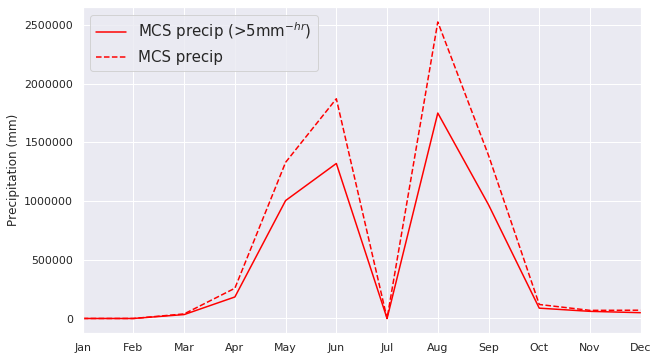

In [79]:
import seaborn as sns 
sns.set()

plt.figure(figsize=(10,6))

plt.plot(seasonal_conv, label = 'MCS precip (>5mm$^{-hr}$)', color= 'red')
plt.plot(seasonal_tot, label = 'MCS precip', color= 'red', linestyle='--')

plt.legend(fontsize= 15)

plt.xticks(np.arange(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'])
plt.xlim(0,11)
plt.ylabel('Precipitation (mm)')



plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/contribution_to_precip.png')
plt.show()


## Basic characterics 

In [ ]:
# density plot of spatial distribution 

In [ ]:
# density intitiation vs. dissipation 

## What is the maximum elevation for cells ? 

## Trends of convective cells in TP region, any change in the past two decades? 